Este cuaderno incluye el código utilizado para el ejemplo: Restauración de imágenes borrosas de la sección 2.6.2 del documento.

# Módulos

In [1]:
from xdesign import SiemensStar, discrete_phantom

import scico.numpy as snp
import scico.random
from scico import functional, linop, loss, metric, plot
from scico.optimize import ProximalADMM
from scico.util import device_info
from skimage.transform import resize

plot.config_notebook_plotting()
from skimage import data, color
from skimage.metrics import structural_similarity, peak_signal_noise_ratio
import numpy as np

## Funciones auxiliares

In [2]:
def normalize(image):
    return (image - image.min()) / (image.max() - image.min())

# Restauración de imágenes borrosas

In [3]:
imagen = color.rgb2gray(data.astronaut())

n = 25  # tamaño del núclo de convolución

psf = snp.ones((n, n)) / (n * n)
C = linop.Convolve(h=psf, input_shape=imagen.shape)

y = C(imagen)

f = functional.ZeroFunctional()
g0 = loss.SquaredL2Loss(y=y)
λ = 5.0e-4  # ℓ2,1 norm regularization parameter
g1 = λ * functional.L21Norm()
g = functional.SeparableFunctional((g0, g1))

D = linop.FiniteDifference(input_shape=imagen.shape, append=0)
A = linop.VerticalStack((C, D))

In [4]:
ρ = 5.0e-2  # ADMM penalty parameter
maxiter = 500  # number of ADMM iterations
mu, nu = ProximalADMM.estimate_parameters(A)

solver = ProximalADMM(
    f=f,
    g=g,
    A=A,
    B=None,
    rho=ρ,
    mu=mu,
    nu=nu,
    x0=C.adj(y),
    maxiter=maxiter,
    itstat_options={"display": True, "period": 10},
)

In [5]:
print(f"Solving on {device_info()}\n")
x = solver.solve()
hist = solver.itstat_object.history(transpose=True)

Solving on CPU

Iter  Time      Objective  Prml Rsdl  Dual Rsdl
-----------------------------------------------
   0  1.12e+00  1.392e+00  2.910e+01  2.550e+02
  10  7.97e+00  1.073e+01  1.355e+01  9.836e-01
  20  1.48e+01  8.215e+00  7.662e+00  6.455e-01
  30  2.16e+01  6.585e+00  4.731e+00  4.611e-01
  40  2.80e+01  5.309e+00  3.262e+00  3.326e-01
  50  3.48e+01  4.497e+00  2.188e+00  2.518e-01
  60  4.12e+01  3.953e+00  1.522e+00  2.042e-01
  70  4.79e+01  3.584e+00  1.066e+00  1.687e-01
  80  5.45e+01  3.326e+00  7.572e-01  1.413e-01
  90  6.13e+01  3.146e+00  5.587e-01  1.178e-01
 100  6.77e+01  3.026e+00  4.183e-01  9.948e-02
 110  7.46e+01  2.944e+00  2.945e-01  8.669e-02
 120  8.18e+01  2.884e+00  2.282e-01  7.658e-02
 130  8.88e+01  2.838e+00  1.722e-01  6.876e-02
 140  9.55e+01  2.802e+00  1.392e-01  6.211e-02
 150  1.02e+02  2.773e+00  1.112e-01  5.703e-02
 160  1.09e+02  2.750e+00  9.193e-02  5.306e-02
 170  1.15e+02  2.729e+00  7.740e-02  4.950e-02
 180  1.22e+02  2.712e+0

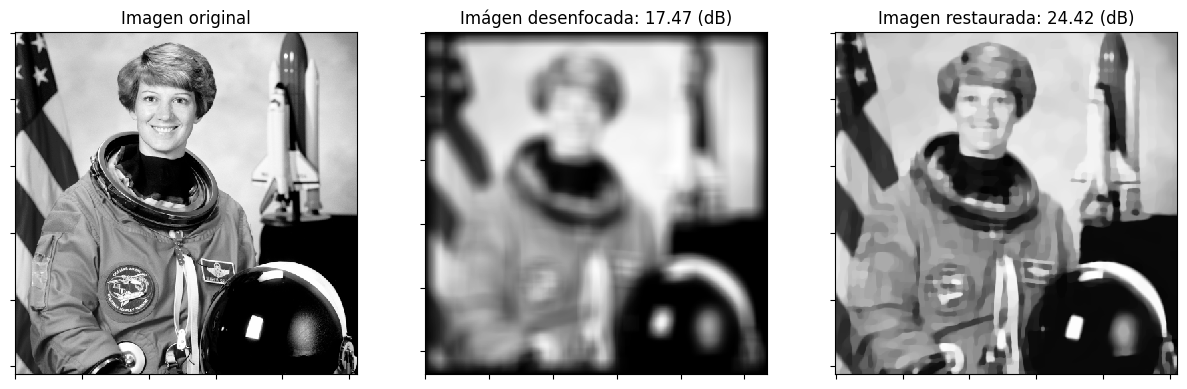

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(imagen, title="Imagen original", fig=fig, ax=ax[0])
nc = n // 2
yc = y[nc:-nc, nc:-nc]
plot.imview(
    y,
    title="Imágen desenfocada: %.2f (dB)" % metric.psnr(imagen, yc),
    fig=fig,
    ax=ax[1],
)
plot.imview(
    solver.x,
    title="Imagen restaurada: %.2f (dB)" % metric.psnr(imagen, solver.x),
    fig=fig,
    ax=ax[2],
)
fig.show()

In [7]:
# calculamos las métricas entre la imágen original, la imagen ruidosa y la imagen sin ruido
ssim_ruidosa = structural_similarity(
    normalize(imagen),
    normalize(resize(y, (512, 512), anti_aliasing=True)),
    data_range=1,
)
ssim_restaurada = structural_similarity(
    normalize(imagen), normalize(np.array(solver.x)), data_range=1
)
psnr_ruidosa = peak_signal_noise_ratio(
    normalize(imagen), resize(y, (512, 512), anti_aliasing=True), data_range=1
)
psnr_restaurada = peak_signal_noise_ratio(
    normalize(imagen), normalize(np.array(solver.x)), data_range=1
)

print(f"SSIM entre la imagen original y la imagen ruidosa: {ssim_ruidosa}")
print(f"SSIM entre la imagen original y la imagen restaurada: {ssim_restaurada}")
print(f"PSNR entre la imagen original y la imagen ruidosa: {psnr_ruidosa}")
print(f"PSNR entre la imagen original y la imagen restaurada: {psnr_restaurada}")

SSIM entre la imagen original y la imagen ruidosa: 0.42824052349263625
SSIM entre la imagen original y la imagen restaurada: 0.6666488341532454
PSNR entre la imagen original y la imagen ruidosa: 14.406279857740232
PSNR entre la imagen original y la imagen restaurada: 23.992269287821934
